In [259]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

In [260]:
data = pd.read_csv('./Dataset/House_Price_Dataset.csv')

In [261]:
data = data[~data['Price'].isnull()]

In [262]:
data['Rooms'] = (data.apply(lambda row: (row.Rooms + row.Rooms2) / 2  if row.Rooms2 else row.Rooms, axis=1))

In [263]:
data = data.drop(columns=['Date', 'Rooms2', 'Address', 'Price', 'Method'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27247 non-null  object 
 1   Rooms          20806 non-null  float64
 2   Type           27247 non-null  object 
 3   Seller         27247 non-null  object 
 4   Distance       27246 non-null  float64
 5   Postcode       27246 non-null  float64
 6   Bathroom       20800 non-null  float64
 7   Car            20423 non-null  float64
 8   Landsize       17982 non-null  float64
 9   BuildingArea   10656 non-null  float64
 10  YearBuilt      12084 non-null  float64
 11  CouncilArea    27244 non-null  object 
 12  Latitude       20993 non-null  float64
 13  Longitude      20993 non-null  float64
 14  RegionName     27244 non-null  object 
 15  PropertyCount  27244 non-null  float64
dtypes: float64(11), object(5)
memory usage: 3.5+ MB


In [264]:
data = data.drop(columns=['Postcode'])

In [265]:
data = data[~data['Rooms'].isnull()]
data = data[~data['Bathroom'].isnull()]
data = data[~data['Latitude'].isnull()]
data = data[~data['Longitude'].isnull()]

## Hot Encoding

In [266]:
def hot_encode(category, df):
    ohe = OneHotEncoder()
    category_col = ohe.fit_transform(df[category].astype(str).values.reshape(-1, 1)).toarray()
    for i in range(len(category_col[0])):
        arr = []
        for x in category_col:
            arr.append(x[i])
        df[f'{category}{i}'] = arr

In [267]:
def hot_encode_many(fields, df):
    for field in fields:
        hot_encode(field, df)

In [268]:
hot_encodable_fields = ['Type', 'CouncilArea']
hot_encode_many(hot_encodable_fields, data)

In [269]:
data = data.drop(columns=hot_encodable_fields+['Suburb', 'RegionName', 'BuildingArea'])

In [270]:
data['Landsize'] = data['Landsize'].replace(['0', 0], np.nan)

In [271]:
## get non-categorical column names

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def get_quantative(column_names):
    for x in column_names:
        if not hasNumbers(x):
            yield x

In [272]:
def fill_null_with_mean(df, columns, from_df):
    if from_df is not None:
        for name in columns:
            df[name].fillna(from_df[name].mean(), inplace=True)
    else:
        for name in columns:
            df[name].fillna(df[name].mean(), inplace=True)

In [273]:
Y = data['Seller']
X = data.drop(columns=['Seller'])
Y = pd.get_dummies(data.Seller)

(X.shape, Y.shape)

((20778, 45), (20778, 321))

In [274]:
quantative_columns = list(get_quantative(X.columns))

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, shuffle=False)

In [276]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
fill_null_with_mean(X_train, quantative_columns, None)

X_test = pd.DataFrame(data=X_test, columns=X.columns)
fill_null_with_mean(X_test, quantative_columns, X_train)

In [277]:
scaler_x = StandardScaler()
x = scaler_x.fit_transform(X_train)

In [278]:
X_scaled_test = scaler_x.transform(X_test)

In [279]:
print(x.shape)
n = x.shape[1]

(16622, 45)


In [280]:
def sample_match(pred, real, open_pred):
    d = {'prediction': [x[0] for x in pred] if open_pred else pred, 'real': real}
    return pd.DataFrame(data=d)

In [281]:
(x.shape, y_train.shape)

((16622, 45), (16622, 321))

# ANN

In [282]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(356, activation='relu'))
model.add(Dense(321, activation='softmax'))

In [283]:
model.compile(optimizer=Adam(lr=0.00001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [284]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.00005)
early_stopping = EarlyStopping(monitor="val_loss", patience=7)
history = model.fit(x, y_train, epochs=200, batch_size=64, validation_split=0.1, 
                  callbacks=[reduce_lr, early_stopping], verbose=0)

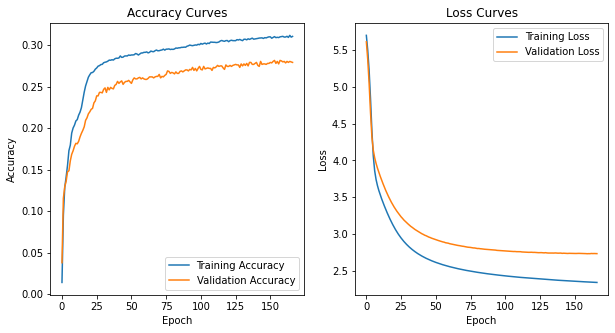

In [285]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()